Student: Vincent Matthys

Mail: vincent.matthys@ens-paris-saclay.fr

# Speech Commands
In this Practical work you will be given voice commands recorded by devices such as assistants. The task is to recognize the voice command from the audio signal. The dataset is stored as waveforms, each one being a 1 second file containing one voice command. The first step will be to extract speech features, either Melfilterbanks or MFCC. Then you will train different type of classifiers to recognize the spoken voice command from the speech features. These classifiers are a Logistic Regression and a Neural Network.

### Replace the path in the shell below by the one that contains the dataset

In [1]:
import numpy as np
import spectral
import librosa
import IPython
import os
import scipy.io.wavfile as wav
import sklearn
from sklearn.neural_network import MLPClassifier
os.chdir('speech_commands_v0.01')
import time
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(777)

These functions are just utilities that will help facilitate features extraction. Feel free to modify them if you need to, but it is not required.

In [2]:
def txt2list(filename):
    lines_list = []
    with open(filename, 'r') as txt:
        for line in txt:
            lines_list.append(line.rstrip('\n'))
    return lines_list

def transform_wavs(wavs_list, feature_func):
    features = []
    for wav in wavs_list:
        features.append(feature_func.transform(wav).flatten())
    return features

def pad(features):
    max_len = 0
    padded_features =[]
    for feat_file in features:
        max_len = max(max_len, feat_file.shape[0])
    for feat_file in features:
        pad_size = max_len - feat_file.shape[0]
        left_pad = pad_size / 2
        right_pad = pad_size - left_pad
        padded_features.append(np.pad(feat_file, ((left_pad, right_pad),), 'constant', constant_values=(0, 0)))
    return padded_features

Load the data. In this practical work, you are expected to train your models on the training set and evaluate them on the validation set. When you will get your final best model, report the results on the test set.

In [11]:
## Loading data
label_set = ['go', 'yes', 'sheila', 'right', 'three', 'cat', 'one', 'on', 'bed', 'nine']
nb_ex_per_class = 300
# Valid set
valid_list = txt2list('validation_list.txt')
# Test set
test_list = txt2list('testing_list.txt')

In [14]:
def init_sets(nb_ex_per_class = 300):
    # Iterate over files
    train_wavs = []
    train_labels = []

    valid_wavs = []
    valid_labels = []

    test_wavs = []
    test_labels = []

    for root, dirs, files in os.walk("."):
        if root == './_background_noise_':
            continue
        for filename in files:
            if not filename.endswith('.wav'):
                continue
            command = root.lstrip('./')
            if command not in label_set:
                continue
            else:
                label = label_set.index(command)
            full_name = os.path.join(root.lstrip('./'), filename)
            fs, waveform = wav.read(full_name)
            if full_name in valid_list and len(valid_labels) < 1000:
                valid_wavs.append(waveform)
                valid_labels.append(label)
            elif full_name in test_list and len(test_labels) < 1000:
                test_wavs.append(waveform)
                test_labels.append(label)
            elif train_labels.count(label) < nb_ex_per_class:
                train_wavs.append(waveform)
                train_labels.append(label)
    # Print data statistics

    print "Train files:" + str(len(train_wavs))
    print "Valid files:" + str(len(valid_wavs))
    print "Test files:" + str(len(test_wavs))
    return train_wavs, train_labels, valid_wavs, valid_labels, test_wavs, test_labels
train_wavs, train_labels, valid_wavs, valid_labels, test_wavs, test_labels = init_sets()

Train files:3000
Valid files:1000
Test files:1000


The following cells create feature functions that have a .transform method that takes a waveform as input. You should not change the framerate parameter (the dataset is sampled at 16kHz).
The other parameters are the following:
* nfilt = number of mel-filters to average spectrograms
* ncep = number of cepstral coefficients to use for MFCCs
* do_dct = True to compute MFCC (otherwise mel-filterbanks are the output)
* lowerf = lowest frequency spanned by the filters (and that will be taken into account by the features)
* higherf = highest frequency spanned by the filters
* alpha = parameter use for the pre-emphasis
* frate = number of frames per second (1/frate is the stride of the windows in seconds)
* wlen = length of windows in seconds
* nfft = number of frequency bins used to compute the spectrogram
* compression = the final compression performed on the mel-filterbanks (before DCT if you put do_dct=True)
* do_deltas = compute the first derivatives of MFCC
* do_deltasdeltas = compute the second derivatives of MFCC

In [15]:
framerate = 16000

# Mel-filterbanks function

In [16]:
help (spectral.Spectral)

Help on class Spectral in module spectral._spectral:

class Spectral(__builtin__.object)
 |  Methods defined here:
 |  
 |  __init__(self, nfilt=40, ncep=13, do_dct=True, lowerf=133.3333, upperf=6855.4976, alpha=0.97, fs=16000, frate=100, wlen=0.01, nfft=512, compression='log', do_deltas=False, do_deltasdeltas=False)
 |  
 |  calc_deltas(self, X)
 |      compute delta coefficients
 |  
 |  calc_deltasdeltas(self, X)
 |  
 |  compressor(self, spec)
 |  
 |  frame2spec(self, frame)
 |  
 |  transform(self, sig)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)
 |  
 |  config



In [17]:
melfbanks = spectral.Spectral(nfilt=40,
                    ncep=0,
                    do_dct=False,
                    lowerf=20,
                    upperf=8000,
                    alpha=0.97,
                    fs=framerate,
                    frate=100,
                    wlen=0.025,
                    nfft=512,
                    compression='log',
                    do_deltas=False,
                    do_deltasdeltas=False)

# MFCC function

In [18]:
mfcc = spectral.Spectral(nfilt=40,
                    ncep=13,
                    do_dct=True,
                    lowerf=20,
                    upperf=8000,
                    alpha=0.97,
                    fs=framerate,
                    frate=100,
                    wlen=0.025,
                    nfft=512,
                    compression='log',
                    do_deltas=True,
                    do_deltasdeltas=False)

# The following cell generates the features for train, valid and test from the waveforms

## MFCC features

In [19]:
# Choose the feature function
feature_function = mfcc

start = time.time()
train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))
end = time.time()

print "Time to output features: " + str(end-start)

Time to output features: 43.2826831341


In [20]:
# Next cell trains a logistic regression on the speech features

In [21]:
#Logistic regression

logreg = sklearn.linear_model.LogisticRegression(verbose=1,
                                                 tol=1e-5,
                                                 C = 1,
                                                 random_state=777,
                                                 solver = "saga",
                                                 multi_class = "multinomial",
                                                 n_jobs = 6)

start = time.time()
logreg.fit(train_feats, train_labels)
end = time.time()

print "Training time: " + str(end-start)

max_iter reached after 78 seconds
Training time: 78.2725219727


/home/vmatthys/anaconda3/envs/TD_1/lib/python2.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:  1.3min finished


# You can now evaluate it on the validation set

In [22]:
# Validation accuracy
print "Accuracy on valid set " + str(100*logreg.score(valid_feats, valid_labels)) + "%"
# Test accuracy
print "Accuracy on test set " + str(100*logreg.score(test_feats, test_labels)) + "%"

Accuracy on valid set 58.3%
Accuracy on test set 58.2%


In [23]:
neural_net = MLPClassifier(hidden_layer_sizes=(400, 40),
                           alpha = 1e-3,
                           validation_fraction = 0.2,
                           verbose = True,
                           random_state = 777,
                           tol = 1e-5,
                           learning_rate_init=0.0005,
                           shuffle = True,
                           max_iter = 400)

start = time.time()
neural_net.fit(train_feats, train_labels)
end = time.time()

print "Training time: " + str(end-start)

Iteration 1, loss = 2.40111587
Iteration 2, loss = 1.98568963
Iteration 3, loss = 1.76244945
Iteration 4, loss = 1.55542313
Iteration 5, loss = 1.39111872
Iteration 6, loss = 1.24800887
Iteration 7, loss = 1.13030626
Iteration 8, loss = 1.04463009
Iteration 9, loss = 0.96875977
Iteration 10, loss = 0.88742296
Iteration 11, loss = 0.80683181
Iteration 12, loss = 0.74642961
Iteration 13, loss = 0.70251579
Iteration 14, loss = 0.65112775
Iteration 15, loss = 0.60210339
Iteration 16, loss = 0.53843254
Iteration 17, loss = 0.48989429
Iteration 18, loss = 0.46936915
Iteration 19, loss = 0.42648445
Iteration 20, loss = 0.38498601
Iteration 21, loss = 0.33770640
Iteration 22, loss = 0.31714723
Iteration 23, loss = 0.29861578
Iteration 24, loss = 0.27573090
Iteration 25, loss = 0.24358568
Iteration 26, loss = 0.22290426
Iteration 27, loss = 0.20745022
Iteration 28, loss = 0.19209135
Iteration 29, loss = 0.17968279
Iteration 30, loss = 0.16234605
Iteration 31, loss = 0.14635462
Iteration 32, los

# Evaluate it on the valid set

In [25]:
# Validation accuracy
print "Accuracy on valid set " + str(100*neural_net.score(valid_feats, valid_labels)) + "%"
# Test accuracy
print "Accuracy on test set " + str(100*neural_net.score(test_feats, test_labels)) + "%"

Accuracy on valid set 80.5%
Accuracy on test set 78.9%


# Listen to a random waveform from the training set

In [26]:
random_idx = random.randint(0, len(valid_wavs))
random_wav = valid_wavs[random_idx]
IPython.display.Audio(random_wav, rate=16000)

# Visualize mel-filterbanks and MFCC

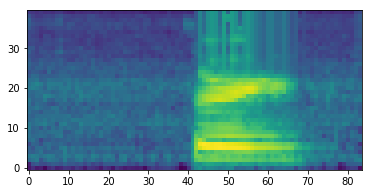

In [27]:
plt.imshow(melfbanks.transform(random_wav).transpose())
plt.gca().invert_yaxis()

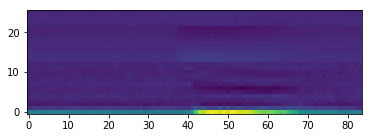

In [28]:
plt.imshow(mfcc.transform(random_wav).transpose())
plt.gca().invert_yaxis()

# See what your classifier has predicted

In [29]:
print label_set[neural_net.predict(valid_feats[random_idx][np.newaxis])[0]]

bed


# What you are expected to do in this TP
This notebook contains the different blocks that allow you to train speech commands recognizers. The results provided with the features and classifiers above are far from optimal.

You are expected to explore various ways to improve their performance. Here are the main things to try:
* The parameters of the speech features such as the min/max frequency or window size are poorly chosen, look inside the resources mentioned in the class to find the best parameters for mel-filterbanks and MFCC.
* The logistic regression can be regularized in different ways (by controlling the C parameter) and you can try to find the best one
* The neural net proposed is a shallow neural net, far from the best you can train. You should try bigger, deeper architectures, different types of regularization, activation functions, learning rate and so on
* A standard way of improving generalization is to do mean-variance normalization on your data set. This is done by computing the mean and variance of each feature dimension on the entire training set, and then use it to normalize train, valid and test set
* The dataset provides noises samples, either artificial (pink, white noise) or real (dishes, bike) in the folder _background_noise. You can try augmenting your dataset by adding noise to the waveforms before computing the features
* The model is only trained on 300 examples per class, if your hardware allows it, try training on more examples
* Feel free to also experiment with different classifiers

You should find the best model by comparing validation accuracies. After you find your best model, finally test it on the test set and print the result. Comment on the results (best model, best features, classes that are the most difficult to recognize). The grade will not depend on the performance of the final system, but on how you experimented, tried different ideas, and comment on them.

Write your comments in Markdown cells, and send the ipython notebook as your assignment. Good luck!

[Documentation for logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

[Documentation for neural network](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

###############################################################################################
###############################################################################################
###############################################################################################
###############################################################################################

# COMMENTS

## Choice of parameters of speech features


For both **Mel-filterbanks and MFCC**, according to:
> Martin, James H., and Daniel Jurafsky. Speech and language processing: An introduction to natural language processing, computational linguistics, and speech recognition. Pearson/Prentice Hall, 2009.

+ Typical value for nfilt is arround 40
+ The best parameters for $\alpha$ is between 0.9 and 1. We choosed $0.97$ as it seems to give the highest score in train.
+ the effective frequency range for speech analysis is below $10kHz$. Given our sampling rate ($16kHz$), to maintain proper sampling according to Shannon, the maximal frequency should not exceed $8Khz$.
+ The typical size of windows is $25~ms$
+ The typical interval between two windows is $10~ms$

We indeed observe that those parameters gave better results in validation. Except for a smaller window size of $10~ms$ which gave better accuracy on both validation and test. But this is too small, and frames do not overlap anymore. We tried larger window ($30~ms$, $40~ms$) size with same frame shift whithout noticing gain in accuracy.

**For MFCC:**
+ the deltas value over the first 12 cepstral features + energy ($ncep = 13$)

## Choice of parameters for logisitc regression
Accuracy in test: $58.2~\%$ (with MFCC), ($54.5~\%$ with melfbanks), with the following `best` parameters

+ scala solver leads to faster convergence and better validation accuracy. The computation time is higher because of the incapacity of using parallelizing while minimizing the multinomial loss.
+ The default value of $C=1$ is fine. Lower than 1, the validation and test accuracy decrese, higher, the accuracy is constant.
+ The one versus logistic regression is not as good as the multiclass regression. 

### With MFCC features

In [30]:
# Choose the feature function
feature_function = mfcc

start = time.time()
train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))
end = time.time()

In [31]:
C_params = {key: {"test": None, "validation": None, "time": None} for key in [0.1, 0.5, 1, 2, 5, 10]}

for k in C_params.keys():
    logreg = sklearn.linear_model.LogisticRegression(verbose=1,
                                                     tol=1e-5,
                                                     C = k,
                                                     random_state=777,
                                                     solver = "saga",
                                                     multi_class = "multinomial")
    start = time.time()
    logreg.fit(train_feats, train_labels)
    end = time.time()
    C_params[k]["time"] = end-start
    C_params[k]["validation"] = 100 * logreg.score(valid_feats, valid_labels)
    C_params[k]["test"] = 100*logreg.score(test_feats, test_labels)

max_iter reached after 33 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.4s finished


max_iter reached after 35 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.6s finished


max_iter reached after 33 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.5s finished


max_iter reached after 35 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.5s finished


max_iter reached after 34 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.1s finished


max_iter reached after 35 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.3s finished


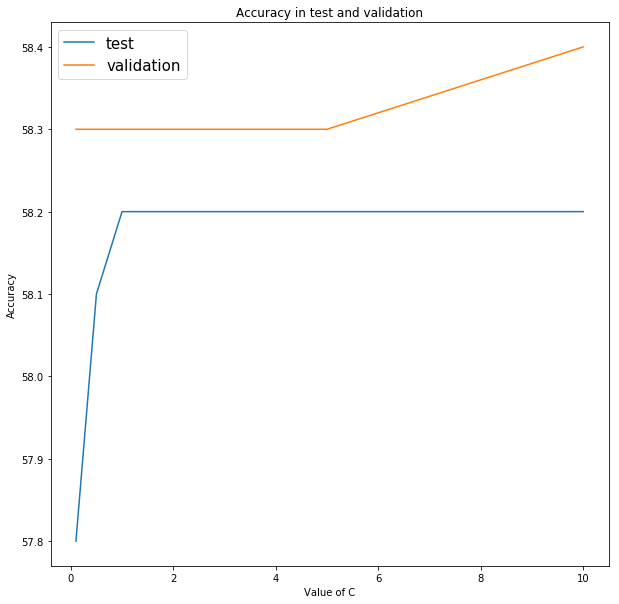

In [32]:
C_test = []
C_validation = []
for k in C_params.keys():
    C_test.append([k, C_params[k]["test"]])
    C_validation.append([k, C_params[k]["validation"]])
C_test = np.sort(np.array(C_test), axis = 0)
C_validation = np.sort(np.array(C_validation), axis = 0)
plt.figure(figsize = (10, 10))
plt.title("Accuracy in test and validation")
plt.plot(C_test[:, 0], C_test[:, 1], label = "test");
plt.plot(C_validation[:, 0], C_validation[:, 1], label = "validation");
plt.xlabel("Value of C");
plt.ylabel("Accuracy");
plt.legend(fontsize = 15);

### With Melfbanks

In [33]:
# Choose the feature function
feature_function = melfbanks
init_sets()
start = time.time()
train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))
end = time.time()

logreg = sklearn.linear_model.LogisticRegression(verbose=1,
                                                 tol=1e-5,
                                                 C = 1,
                                                 random_state=777,
                                                 solver = "saga",
                                                 multi_class = "multinomial",
                                                 n_jobs = 6)
logreg.fit(train_feats, train_labels)

Train files:3000
Valid files:1000
Test files:1000
max_iter reached after 53 seconds


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:   52.8s finished


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=6, penalty='l2', random_state=777, solver='saga',
          tol=1e-05, verbose=1, warm_start=False)

In [34]:
# Validation accuracy
print "Accuracy on valid set " + str(100*logreg.score(valid_feats, valid_labels)) + "%"
# Test accuracy
print "Accuracy on test set " + str(100*logreg.score(test_feats, test_labels)) + "%"

Accuracy on valid set 56.7%
Accuracy on test set 54.5%


## Choice of parameters of MLP classifier


Accuracy in test: $79.2\%$ (with MFCC), $52.8~\%$ with melfbanks , with the following `best` parameters

+ the architecture giving the best accuracy in validation is (400, 200), with 2 hidden layers.
+ the best alpha is $1~10^{-3}$
+ the proper learning rate is arround $5~10^{-4}$ for this architecture
+ the number of examples per class increases the accuracy, both in validation and in test. We can notice a gap in accuracy below 100 examples per class.

### Choice of architecture

In [39]:
# arch_params = {key: {"test": None, "validation": None, "time": None} for key in [(100,), (200,), (300,), (400,), (400, 40), (400, 200), (400, 200, 40)]}
# Choose the feature function
feature_function = mfcc

start = time.time()
train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))
end = time.time()

In [40]:
KEYS = [(100,), (200,), (300,), (400,), (400, 40), (400, 200), (400, 200, 40)]
arch_params = {}

for k in KEYS:
    arch_params[k] = {}
    print ("Current architecture: {}".format(k))
    neural_net = MLPClassifier(hidden_layer_sizes=k,
                           alpha = 1e-3,
                           validation_fraction = 0.2,
                           verbose = True,
                           random_state = 777,
                           tol = 1e-5,
                           learning_rate_init=0.0005,
                           shuffle = True,
                           max_iter = 400)
    start = time.time()
    neural_net.fit(train_feats, train_labels)
    end = time.time()
    arch_params[k] = {}
    arch_params[k]["time"] = end-start
    arch_params[k]["validation"] = 100 * neural_net.score(valid_feats, valid_labels)
    arch_params[k]["test"] = 100*neural_net.score(test_feats, test_labels)

Current architecture: (100,)
Iteration 1, loss = 2.52482189
Iteration 2, loss = 1.90829015
Iteration 3, loss = 1.64450150
Iteration 4, loss = 1.47331462
Iteration 5, loss = 1.34765754
Iteration 6, loss = 1.26920425
Iteration 7, loss = 1.17066069
Iteration 8, loss = 1.10543373
Iteration 9, loss = 1.03643266
Iteration 10, loss = 0.97743008
Iteration 11, loss = 0.92474569
Iteration 12, loss = 0.87161728
Iteration 13, loss = 0.83523416
Iteration 14, loss = 0.77549392
Iteration 15, loss = 0.74257737
Iteration 16, loss = 0.70621264
Iteration 17, loss = 0.67420383
Iteration 18, loss = 0.63642488
Iteration 19, loss = 0.61746746
Iteration 20, loss = 0.57581178
Iteration 21, loss = 0.53707057
Iteration 22, loss = 0.52181075
Iteration 23, loss = 0.50609782
Iteration 24, loss = 0.46707347
Iteration 25, loss = 0.45249467
Iteration 26, loss = 0.42498964
Iteration 27, loss = 0.40297542
Iteration 28, loss = 0.37582648
Iteration 29, loss = 0.36072284
Iteration 30, loss = 0.35680034
Iteration 31, loss =

Iteration 252, loss = 0.00422008
Iteration 253, loss = 0.00419405
Iteration 254, loss = 0.00417481
Iteration 255, loss = 0.00415441
Iteration 256, loss = 0.00414482
Iteration 257, loss = 0.00412969
Iteration 258, loss = 0.00409294
Iteration 259, loss = 0.00407295
Iteration 260, loss = 0.00406216
Iteration 261, loss = 0.00405937
Iteration 262, loss = 0.00403283
Iteration 263, loss = 0.00400415
Iteration 264, loss = 0.00398957
Iteration 265, loss = 0.00398578
Iteration 266, loss = 0.00396778
Iteration 267, loss = 0.00393801
Iteration 268, loss = 0.00392494
Iteration 269, loss = 0.00391365
Iteration 270, loss = 0.00389967
Iteration 271, loss = 0.00388072
Iteration 272, loss = 0.00385726
Iteration 273, loss = 0.00384882
Iteration 274, loss = 0.00384132
Iteration 275, loss = 0.00382488
Iteration 276, loss = 0.00379751
Iteration 277, loss = 0.00377213
Iteration 278, loss = 0.00376685
Iteration 279, loss = 0.00376443
Iteration 280, loss = 0.00373673
Iteration 281, loss = 0.00372133
Iteration 

Iteration 171, loss = 0.00576609
Iteration 172, loss = 0.00572371
Iteration 173, loss = 0.00564219
Iteration 174, loss = 0.00561946
Iteration 175, loss = 0.00558518
Iteration 176, loss = 0.00552893
Iteration 177, loss = 0.00547186
Iteration 178, loss = 0.00544971
Iteration 179, loss = 0.00542929
Iteration 180, loss = 0.00539915
Iteration 181, loss = 0.00535704
Iteration 182, loss = 0.00531144
Iteration 183, loss = 0.00526620
Iteration 184, loss = 0.00523938
Iteration 185, loss = 0.00519953
Iteration 186, loss = 0.00516893
Iteration 187, loss = 0.00514066
Iteration 188, loss = 0.00515241
Iteration 189, loss = 0.00509040
Iteration 190, loss = 0.00505766
Iteration 191, loss = 0.00505253
Iteration 192, loss = 0.00500040
Iteration 193, loss = 0.00495162
Iteration 194, loss = 0.00494680
Iteration 195, loss = 0.00491538
Iteration 196, loss = 0.00490069
Iteration 197, loss = 0.00485155
Iteration 198, loss = 0.00484505
Iteration 199, loss = 0.00480178
Iteration 200, loss = 0.00478106
Iteration 

Iteration 110, loss = 0.00904216
Iteration 111, loss = 0.00891775
Iteration 112, loss = 0.00882205
Iteration 113, loss = 0.00866229
Iteration 114, loss = 0.00855122
Iteration 115, loss = 0.00838895
Iteration 116, loss = 0.00831877
Iteration 117, loss = 0.00820974
Iteration 118, loss = 0.00810391
Iteration 119, loss = 0.00798861
Iteration 120, loss = 0.00790197
Iteration 121, loss = 0.00783413
Iteration 122, loss = 0.00778789
Iteration 123, loss = 0.00766154
Iteration 124, loss = 0.00754298
Iteration 125, loss = 0.00745474
Iteration 126, loss = 0.00737168
Iteration 127, loss = 0.00728270
Iteration 128, loss = 0.00725319
Iteration 129, loss = 0.00714776
Iteration 130, loss = 0.00709124
Iteration 131, loss = 0.00705080
Iteration 132, loss = 0.00697934
Iteration 133, loss = 0.00688558
Iteration 134, loss = 0.00682799
Iteration 135, loss = 0.00676731
Iteration 136, loss = 0.00669785
Iteration 137, loss = 0.00662712
Iteration 138, loss = 0.00655927
Iteration 139, loss = 0.00648696
Iteration 

Iteration 126, loss = 0.00655611
Iteration 127, loss = 0.00651353
Iteration 128, loss = 0.00642739
Iteration 129, loss = 0.00639847
Iteration 130, loss = 0.00634689
Iteration 131, loss = 0.00629184
Iteration 132, loss = 0.00627304
Iteration 133, loss = 0.00620296
Iteration 134, loss = 0.00615135
Iteration 135, loss = 0.00612115
Iteration 136, loss = 0.00605740
Iteration 137, loss = 0.00600732
Iteration 138, loss = 0.00595585
Iteration 139, loss = 0.00591269
Iteration 140, loss = 0.00587742
Iteration 141, loss = 0.00585326
Iteration 142, loss = 0.00579998
Iteration 143, loss = 0.00577189
Iteration 144, loss = 0.00574245
Iteration 145, loss = 0.00569949
Iteration 146, loss = 0.00565249
Iteration 147, loss = 0.00561016
Iteration 148, loss = 0.00559141
Iteration 149, loss = 0.00558293
Iteration 150, loss = 0.00553725
Iteration 151, loss = 0.00550672
Iteration 152, loss = 0.00546825
Iteration 153, loss = 0.00543613
Iteration 154, loss = 0.00540399
Iteration 155, loss = 0.00537589
Iteration 

Iteration 137, loss = 0.00501303
Iteration 138, loss = 0.00497657
Iteration 139, loss = 0.00495026
Iteration 140, loss = 0.00492572
Iteration 141, loss = 0.00490363
Iteration 142, loss = 0.00487788
Iteration 143, loss = 0.00485641
Iteration 144, loss = 0.00484198
Iteration 145, loss = 0.00482563
Iteration 146, loss = 0.00479693
Iteration 147, loss = 0.00477112
Iteration 148, loss = 0.00474473
Iteration 149, loss = 0.00471681
Iteration 150, loss = 0.00469692
Iteration 151, loss = 0.00468313
Iteration 152, loss = 0.00466906
Iteration 153, loss = 0.00464348
Iteration 154, loss = 0.00462013
Iteration 155, loss = 0.00459925
Iteration 156, loss = 0.00457479
Iteration 157, loss = 0.00456076
Iteration 158, loss = 0.00455796
Iteration 159, loss = 0.00453180
Iteration 160, loss = 0.00451354
Iteration 161, loss = 0.00449356
Iteration 162, loss = 0.00447683
Iteration 163, loss = 0.00445114
Iteration 164, loss = 0.00443514
Iteration 165, loss = 0.00442118
Iteration 166, loss = 0.00440691
Iteration 

Iteration 14, loss = 0.40285502
Iteration 15, loss = 0.34353184
Iteration 16, loss = 0.30371108
Iteration 17, loss = 0.28315539
Iteration 18, loss = 0.24191723
Iteration 19, loss = 0.21336945
Iteration 20, loss = 0.17602300
Iteration 21, loss = 0.14993201
Iteration 22, loss = 0.14974691
Iteration 23, loss = 0.13973534
Iteration 24, loss = 0.11910741
Iteration 25, loss = 0.09487551
Iteration 26, loss = 0.08289272
Iteration 27, loss = 0.08276373
Iteration 28, loss = 0.07172210
Iteration 29, loss = 0.06102737
Iteration 30, loss = 0.04827432
Iteration 31, loss = 0.04015716
Iteration 32, loss = 0.03735469
Iteration 33, loss = 0.03206778
Iteration 34, loss = 0.02919643
Iteration 35, loss = 0.02816624
Iteration 36, loss = 0.02568924
Iteration 37, loss = 0.02322327
Iteration 38, loss = 0.01977335
Iteration 39, loss = 0.01836009
Iteration 40, loss = 0.01731266
Iteration 41, loss = 0.01600420
Iteration 42, loss = 0.01546022
Iteration 43, loss = 0.01452244
Iteration 44, loss = 0.01379054
Iteratio

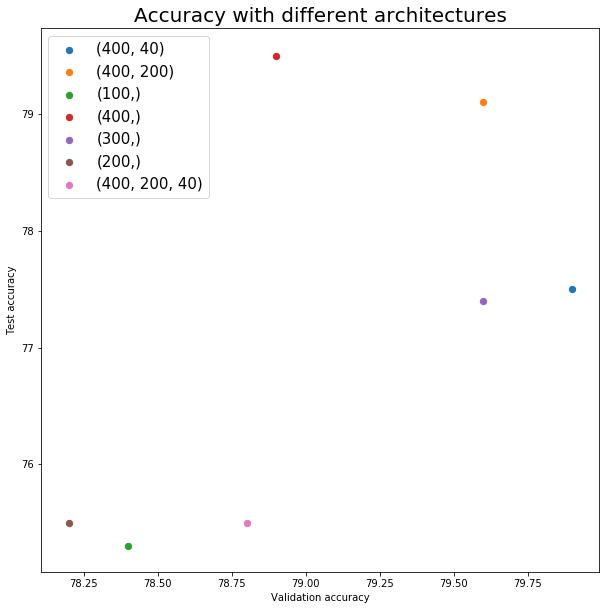

In [41]:
plt.figure(figsize = (10, 10))
plt.title("Accuracy with different architectures", fontsize = 20)
for k in arch_params.keys():
    plt.scatter(arch_params[k]["validation"], arch_params[k]["test"], s = 40, label = k)
plt.xlabel("Validation accuracy");
plt.ylabel("Test accuracy");
plt.legend(fontsize = 15);

### Choice of alpha

In [42]:
alpha_params = {key: {"test": None, "validation": None, "time": None} for key in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}

for k in alpha_params.keys():
    neural_net = MLPClassifier(hidden_layer_sizes=(400, 40),
                           alpha = k,
                           validation_fraction = 0.2,
                           verbose = True,
                           random_state = 777,
                           tol = 1e-5,
                           learning_rate_init=0.0005,
                           shuffle = True,
                           max_iter = 400)
    start = time.time()
    neural_net.fit(train_feats, train_labels)
    end = time.time()
    alpha_params[k]["time"] = end-start
    alpha_params[k]["validation"] = 100 * neural_net.score(valid_feats, valid_labels)
    alpha_params[k]["test"] = 100*neural_net.score(test_feats, test_labels)

Iteration 1, loss = 2.40111588
Iteration 2, loss = 1.98568964
Iteration 3, loss = 1.76244947
Iteration 4, loss = 1.55542314
Iteration 5, loss = 1.39111872
Iteration 6, loss = 1.24800890
Iteration 7, loss = 1.13030629
Iteration 8, loss = 1.04463010
Iteration 9, loss = 0.96875977
Iteration 10, loss = 0.88742296
Iteration 11, loss = 0.80676057
Iteration 12, loss = 0.74615173
Iteration 13, loss = 0.70218986
Iteration 14, loss = 0.65251760
Iteration 15, loss = 0.60429515
Iteration 16, loss = 0.54080770
Iteration 17, loss = 0.49550233
Iteration 18, loss = 0.47052450
Iteration 19, loss = 0.43119219
Iteration 20, loss = 0.38717913
Iteration 21, loss = 0.34061858
Iteration 22, loss = 0.33080904
Iteration 23, loss = 0.30983201
Iteration 24, loss = 0.28316220
Iteration 25, loss = 0.25062908
Iteration 26, loss = 0.22465530
Iteration 27, loss = 0.21057483
Iteration 28, loss = 0.19514868
Iteration 29, loss = 0.17861431
Iteration 30, loss = 0.16240967
Iteration 31, loss = 0.14751936
Iteration 32, los

Iteration 39, loss = 0.06203761
Iteration 40, loss = 0.06062926
Iteration 41, loss = 0.05427741
Iteration 42, loss = 0.05117602
Iteration 43, loss = 0.04751704
Iteration 44, loss = 0.04311877
Iteration 45, loss = 0.04002793
Iteration 46, loss = 0.03683069
Iteration 47, loss = 0.03341808
Iteration 48, loss = 0.03122599
Iteration 49, loss = 0.02997319
Iteration 50, loss = 0.02800106
Iteration 51, loss = 0.02591933
Iteration 52, loss = 0.02426566
Iteration 53, loss = 0.02303685
Iteration 54, loss = 0.02199929
Iteration 55, loss = 0.02111138
Iteration 56, loss = 0.01957611
Iteration 57, loss = 0.01825225
Iteration 58, loss = 0.01751723
Iteration 59, loss = 0.01639079
Iteration 60, loss = 0.01580879
Iteration 61, loss = 0.01517701
Iteration 62, loss = 0.01445979
Iteration 63, loss = 0.01370203
Iteration 64, loss = 0.01319236
Iteration 65, loss = 0.01237939
Iteration 66, loss = 0.01196910
Iteration 67, loss = 0.01123183
Iteration 68, loss = 0.01071550
Iteration 69, loss = 0.01037005
Iteratio

Iteration 113, loss = 0.00254228
Iteration 114, loss = 0.00245534
Iteration 115, loss = 0.00241889
Iteration 116, loss = 0.00235040
Iteration 117, loss = 0.00231384
Iteration 118, loss = 0.00226833
Iteration 119, loss = 0.00222414
Iteration 120, loss = 0.00219569
Iteration 121, loss = 0.00214320
Iteration 122, loss = 0.00209484
Iteration 123, loss = 0.00204726
Iteration 124, loss = 0.00200116
Iteration 125, loss = 0.00198337
Iteration 126, loss = 0.00193274
Iteration 127, loss = 0.00190270
Iteration 128, loss = 0.00186971
Iteration 129, loss = 0.00183187
Iteration 130, loss = 0.00179377
Iteration 131, loss = 0.00176781
Iteration 132, loss = 0.00171446
Iteration 133, loss = 0.00168499
Iteration 134, loss = 0.00167444
Iteration 135, loss = 0.00164043
Iteration 136, loss = 0.00160289
Iteration 137, loss = 0.00157923
Iteration 138, loss = 0.00154164
Iteration 139, loss = 0.00151970
Iteration 140, loss = 0.00150012
Iteration 141, loss = 0.00147718
Iteration 142, loss = 0.00145208
Iteration 

Iteration 84, loss = 0.03409331
Iteration 85, loss = 0.03381745
Iteration 86, loss = 0.03352017
Iteration 87, loss = 0.03320118
Iteration 88, loss = 0.03298729
Iteration 89, loss = 0.03271246
Iteration 90, loss = 0.03250691
Iteration 91, loss = 0.03235710
Iteration 92, loss = 0.03207123
Iteration 93, loss = 0.03188438
Iteration 94, loss = 0.03167236
Iteration 95, loss = 0.03146352
Iteration 96, loss = 0.03129918
Iteration 97, loss = 0.03113268
Iteration 98, loss = 0.03086440
Iteration 99, loss = 0.03062711
Iteration 100, loss = 0.03054156
Iteration 101, loss = 0.03039002
Iteration 102, loss = 0.03009278
Iteration 103, loss = 0.02990495
Iteration 104, loss = 0.02970105
Iteration 105, loss = 0.02959944
Iteration 106, loss = 0.02935953
Iteration 107, loss = 0.02922935
Iteration 108, loss = 0.02899283
Iteration 109, loss = 0.02881387
Iteration 110, loss = 0.02867572
Iteration 111, loss = 0.02853583
Iteration 112, loss = 0.02833554
Iteration 113, loss = 0.02819973
Iteration 114, loss = 0.02

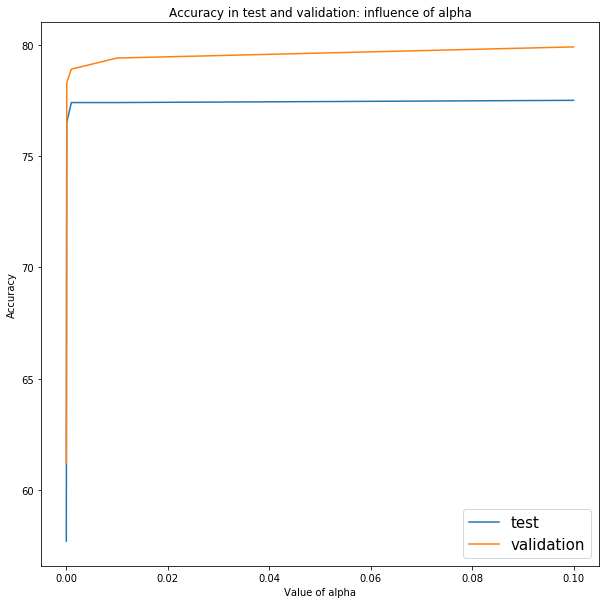

In [43]:
alpha_test = []
alpha_validation = []
for k in alpha_params.keys():
    alpha_test.append([k, alpha_params[k]["test"]])
    alpha_validation.append([k, alpha_params[k]["validation"]])
alpha_test = np.sort(np.array(alpha_test), axis = 0)
alpha_validation = np.sort(np.array(alpha_validation), axis = 0)
plt.figure(figsize = (10, 10))
plt.title("Accuracy in test and validation: influence of alpha")
plt.plot(alpha_test[:, 0], alpha_test[:, 1], label = "test");
plt.plot(alpha_validation[:, 0], alpha_validation[:, 1], label = "validation");
plt.xlabel("Value of alpha");
plt.ylabel("Accuracy");
plt.legend(fontsize = 15);

### Number of examples per class

In [ ]:
# nbr_params = {key: {"test": None, "validation": None, "time": None} for key in [300, 400, 500]}

In [45]:
KEYS = [100, 300, 500, 800, 1000]
nbr_params = {}

for k in KEYS:
    nbr_params[k] = {}
    train_wavs, train_labels, valid_wavs, valid_labels, test_wavs, test_labels = init_sets(nb_ex_per_class = k)
    feature_function = mfcc
    train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
    valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
    test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))

    neural_net = MLPClassifier(hidden_layer_sizes=(400, 40),
                           alpha = 1e-3,
                           validation_fraction = 0.2,
                           verbose = True,
                           random_state = 777,
                           tol = 1e-5,
                           learning_rate_init=0.0005,
                           shuffle = True,
                           max_iter = 400)
    start = time.time()
    neural_net.fit(train_feats, train_labels)
    end = time.time()
    nbr_params[k]["time"] = end-start
    nbr_params[k]["validation"] = 100 * neural_net.score(valid_feats, valid_labels)
    nbr_params[k]["test"] = 100*neural_net.score(test_feats, test_labels)

Train files:1000
Valid files:1000
Test files:1000
Iteration 1, loss = 2.75321415
Iteration 2, loss = 2.21850488
Iteration 3, loss = 2.11524694
Iteration 4, loss = 1.97826227
Iteration 5, loss = 1.83817593
Iteration 6, loss = 1.73444222
Iteration 7, loss = 1.62273280
Iteration 8, loss = 1.55156585
Iteration 9, loss = 1.44772125
Iteration 10, loss = 1.32108571
Iteration 11, loss = 1.23289323
Iteration 12, loss = 1.13384690
Iteration 13, loss = 1.04568569
Iteration 14, loss = 0.97495788
Iteration 15, loss = 0.92635980
Iteration 16, loss = 0.85226226
Iteration 17, loss = 0.77569719
Iteration 18, loss = 0.71509794
Iteration 19, loss = 0.66393566
Iteration 20, loss = 0.62119237
Iteration 21, loss = 0.56292331
Iteration 22, loss = 0.53460779
Iteration 23, loss = 0.50407698
Iteration 24, loss = 0.46812317
Iteration 25, loss = 0.45749630
Iteration 26, loss = 0.42713904
Iteration 27, loss = 0.39216171
Iteration 28, loss = 0.36115841
Iteration 29, loss = 0.33684176
Iteration 30, loss = 0.30996215

Iteration 253, loss = 0.00384915
Iteration 254, loss = 0.00383690
Iteration 255, loss = 0.00382648
Iteration 256, loss = 0.00381607
Iteration 257, loss = 0.00381010
Iteration 258, loss = 0.00379804
Iteration 259, loss = 0.00378802
Iteration 260, loss = 0.00377777
Iteration 261, loss = 0.00376832
Iteration 262, loss = 0.00376275
Iteration 263, loss = 0.00375011
Iteration 264, loss = 0.00374085
Iteration 265, loss = 0.00373206
Iteration 266, loss = 0.00372290
Training loss did not improve more than tol=0.000010 for two consecutive epochs. Stopping.
Train files:3000
Valid files:1000
Test files:1000
Iteration 1, loss = 2.40111587
Iteration 2, loss = 1.98568963
Iteration 3, loss = 1.76244945
Iteration 4, loss = 1.55542313
Iteration 5, loss = 1.39111872
Iteration 6, loss = 1.24800887
Iteration 7, loss = 1.13030626
Iteration 8, loss = 1.04463009
Iteration 9, loss = 0.96875977
Iteration 10, loss = 0.88742296
Iteration 11, loss = 0.80683181
Iteration 12, loss = 0.74642961
Iteration 13, loss = 0

Iteration 33, loss = 0.07259674
Iteration 34, loss = 0.06336557
Iteration 35, loss = 0.05128332
Iteration 36, loss = 0.04734499
Iteration 37, loss = 0.04288900
Iteration 38, loss = 0.03852478
Iteration 39, loss = 0.03572394
Iteration 40, loss = 0.03338093
Iteration 41, loss = 0.03176531
Iteration 42, loss = 0.02785909
Iteration 43, loss = 0.02558882
Iteration 44, loss = 0.02464792
Iteration 45, loss = 0.02411305
Iteration 46, loss = 0.02241898
Iteration 47, loss = 0.02071013
Iteration 48, loss = 0.02008428
Iteration 49, loss = 0.01860375
Iteration 50, loss = 0.01724378
Iteration 51, loss = 0.01682514
Iteration 52, loss = 0.01597370
Iteration 53, loss = 0.01494339
Iteration 54, loss = 0.01418046
Iteration 55, loss = 0.01352842
Iteration 56, loss = 0.01339844
Iteration 57, loss = 0.01283897
Iteration 58, loss = 0.01224140
Iteration 59, loss = 0.01187961
Iteration 60, loss = 0.01145305
Iteration 61, loss = 0.01094193
Iteration 62, loss = 0.01076630
Iteration 63, loss = 0.01053777
Iteratio

Iteration 40, loss = 0.01914064
Iteration 41, loss = 0.01810100
Iteration 42, loss = 0.01674261
Iteration 43, loss = 0.01574676
Iteration 44, loss = 0.01519352
Iteration 45, loss = 0.01425594
Iteration 46, loss = 0.01334266
Iteration 47, loss = 0.01253350
Iteration 48, loss = 0.01215994
Iteration 49, loss = 0.01161624
Iteration 50, loss = 0.01132211
Iteration 51, loss = 0.01095216
Iteration 52, loss = 0.01040692
Iteration 53, loss = 0.00999485
Iteration 54, loss = 0.00962869
Iteration 55, loss = 0.00942627
Iteration 56, loss = 0.00917501
Iteration 57, loss = 0.00899056
Iteration 58, loss = 0.00870417
Iteration 59, loss = 0.00856097
Iteration 60, loss = 0.00836469
Iteration 61, loss = 0.00818368
Iteration 62, loss = 0.00800086
Iteration 63, loss = 0.00779245
Iteration 64, loss = 0.00765121
Iteration 65, loss = 0.00751343
Iteration 66, loss = 0.00734421
Iteration 67, loss = 0.00722309
Iteration 68, loss = 0.00712858
Iteration 69, loss = 0.00700932
Iteration 70, loss = 0.00690462
Iteratio

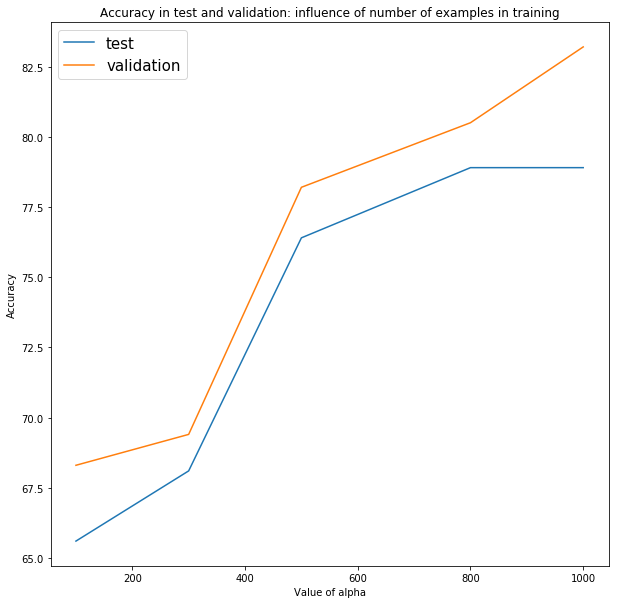

In [46]:
nbr_test = []
nbr_validation = []
for k in nbr_params.keys():
    nbr_test.append([k, nbr_params[k]["test"]])
    nbr_validation.append([k, nbr_params[k]["validation"]])
nbr_test = np.sort(np.array(nbr_test), axis = 0)
nbr_validation = np.sort(np.array(nbr_validation), axis = 0)
plt.figure(figsize = (10, 10))
plt.title("Accuracy in test and validation: influence of number of examples in training")
plt.plot(nbr_test[:, 0], nbr_test[:, 1], label = "test");
plt.plot(nbr_validation[:, 0], nbr_validation[:, 1], label = "validation");
plt.xlabel("Value of alpha");
plt.ylabel("Accuracy");
plt.legend(fontsize = 15);

### With melfbanks

In [47]:
train_wavs, train_labels, valid_wavs, valid_labels, test_wavs, test_labels = init_sets(nb_ex_per_class = 300)
feature_function = melfbanks
train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))

Train files:3000
Valid files:1000
Test files:1000


In [48]:
neural_net = MLPClassifier(hidden_layer_sizes=(400, 40),
                       alpha = 1e-3,
                       validation_fraction = 0.2,
                       verbose = True,
                       random_state = 777,
                       tol = 1e-5,
                       learning_rate_init=0.0001,
                       shuffle = True,
                       max_iter = 400)
start = time.time()
neural_net.fit(train_feats, train_labels)
end = time.time()
# Validation accuracy
print "Accuracy on valid set " + str(100*neural_net.score(valid_feats, valid_labels)) + "%"
# Test accuracy
print "Accuracy on test set " + str(100*neural_net.score(test_feats, test_labels)) + "%"

Iteration 1, loss = 5.83224837
Iteration 2, loss = 2.48674581
Iteration 3, loss = 2.29384756
Iteration 4, loss = 2.24983714
Iteration 5, loss = 2.22675397
Iteration 6, loss = 2.18522232
Iteration 7, loss = 2.17205297
Iteration 8, loss = 2.13182594
Iteration 9, loss = 2.10936052
Iteration 10, loss = 2.07167748
Iteration 11, loss = 2.04515718
Iteration 12, loss = 2.01904255
Iteration 13, loss = 1.99490909
Iteration 14, loss = 1.97014748
Iteration 15, loss = 1.94981580
Iteration 16, loss = 1.93618400
Iteration 17, loss = 1.90188149
Iteration 18, loss = 1.87634720
Iteration 19, loss = 1.88398120
Iteration 20, loss = 1.88606705
Iteration 21, loss = 1.86654152
Iteration 22, loss = 1.83841099
Iteration 23, loss = 1.82823545
Iteration 24, loss = 1.78961023
Iteration 25, loss = 1.78220348
Iteration 26, loss = 1.77199931
Iteration 27, loss = 1.73738849
Iteration 28, loss = 1.72438026
Iteration 29, loss = 1.70451617
Iteration 30, loss = 1.66853665
Iteration 31, loss = 1.64960777
Iteration 32, los

## Specific cases
The confusion matrix shows that the worst cases in test are for the words "right" and "one", which are often recognized as "three" and "on" respectively. We can expect this poor result on "one" versus "on", which share a very similar spectrum, as presented below. On the other side, the word "yes" is recognized in 90% of cases.

In [50]:
# Get the best model
feature_function = mfcc

start = time.time()
train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))
end = time.time()

neural_net = MLPClassifier(hidden_layer_sizes=(400, 40),
                           alpha = 1e-3,
                           validation_fraction = 0.2,
                           verbose = True,
                           random_state = 777,
                           tol = 1e-5,
                           learning_rate_init=0.0005,
                           shuffle = True,
                           max_iter = 400)
neural_net.fit(train_feats, train_labels)
# Validation accuracy
print "Accuracy on valid set " + str(100*neural_net.score(valid_feats, valid_labels)) + "%"
# Test accuracy
print "Accuracy on test set " + str(100*neural_net.score(test_feats, test_labels)) + "%"

Iteration 1, loss = 2.40111587
Iteration 2, loss = 1.98568963
Iteration 3, loss = 1.76244945
Iteration 4, loss = 1.55542313
Iteration 5, loss = 1.39111872
Iteration 6, loss = 1.24800887
Iteration 7, loss = 1.13030626
Iteration 8, loss = 1.04463009
Iteration 9, loss = 0.96875977
Iteration 10, loss = 0.88742296
Iteration 11, loss = 0.80683181
Iteration 12, loss = 0.74642961
Iteration 13, loss = 0.70251579
Iteration 14, loss = 0.65112775
Iteration 15, loss = 0.60210339
Iteration 16, loss = 0.53843254
Iteration 17, loss = 0.48989429
Iteration 18, loss = 0.46936915
Iteration 19, loss = 0.42648445
Iteration 20, loss = 0.38498601
Iteration 21, loss = 0.33770640
Iteration 22, loss = 0.31714723
Iteration 23, loss = 0.29861578
Iteration 24, loss = 0.27573090
Iteration 25, loss = 0.24358568
Iteration 26, loss = 0.22290426
Iteration 27, loss = 0.20745022
Iteration 28, loss = 0.19209135
Iteration 29, loss = 0.17968279
Iteration 30, loss = 0.16234605
Iteration 31, loss = 0.14635462
Iteration 32, los

### One Versus On

#### One

In [51]:
one = train_wavs[(np.array(train_labels) == label_set.index("one")).argmax()]
IPython.display.Audio(one, rate=16000)

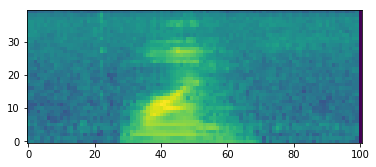

In [52]:
plt.imshow(melfbanks.transform(one).transpose())
plt.gca().invert_yaxis()

#### On

In [53]:
on = train_wavs[(np.array(train_labels) == label_set.index("on")).argmax()]
IPython.display.Audio(on, rate=16000)

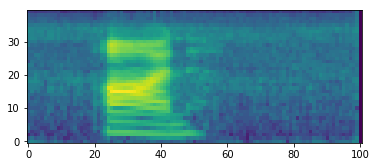

In [54]:
plt.imshow(melfbanks.transform(on).transpose())
plt.gca().invert_yaxis()

### Confusion matrix

In [55]:
print label_set[neural_net.predict(valid_feats[random_idx][np.newaxis])[0]]

bed


In [56]:
nbr_classes = len(label_set)
res = np.zeros((nbr_classes, 1))
for d in range(len(valid_wavs)):
     if valid_labels[d] == neural_net.predict(valid_feats[d][np.newaxis])[0]:
            res[valid_labels[d]] += 1
for k in range(nbr_classes):
    res[k, 0] /= np.maximum((np.array(valid_labels) == k).sum(), 1)

In [57]:
res

array([[ 0.        ],
       [ 0.90421456],
       [ 0.        ],
       [ 0.75      ],
       [ 0.85887097],
       [ 0.        ],
       [ 0.6826087 ],
       [ 0.        ],
       [ 0.76649746],
       [ 0.        ]])

In [58]:
nbr_classes = len(label_set)
res = np.zeros((nbr_classes, nbr_classes))
for d in range(len(valid_wavs)):
    res[valid_labels[d], neural_net.predict(valid_feats[d][np.newaxis])[0]] += 1
for k in range(nbr_classes):
    res[k, :] /= np.maximum((np.array(valid_labels) == k).sum(), 1)

In [59]:
res

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.00383142,  0.90421456,  0.00383142,  0.01532567,  0.02298851,
         0.02681992,  0.00383142,  0.00383142,  0.01532567,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.03125   ,  0.        ,  0.75      ,  0.09375   ,
         0.        ,  0.03125   ,  0.        ,  0.078125  ,  0.015625  ],
       [ 0.00806452,  0.00403226,  0.01209677,  0.01612903,  0.85887097,
         0.00806452,  0.        ,  0.00806452,  0.06451613,  0.02016129],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.02173913,  0.        ,  0.00434783,  0.04782609,  0.0173913 ,
         0.01304348,  0.6826087 ,  0.13478261

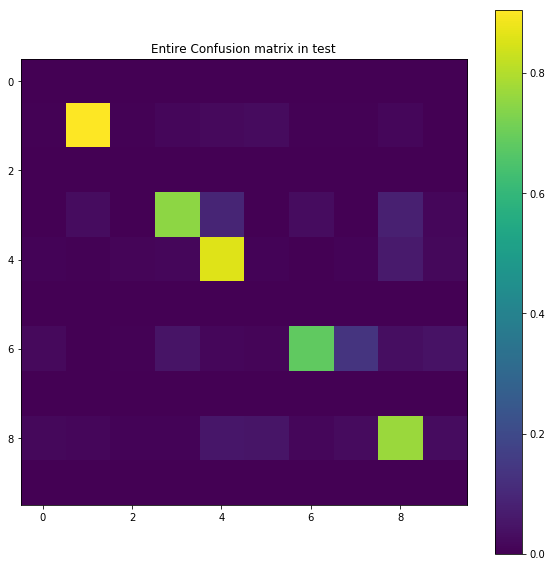

In [60]:
plt.figure(figsize = (10, 10));
plt.title("Entire Confusion matrix in test")
plt.imshow(res);
plt.colorbar();

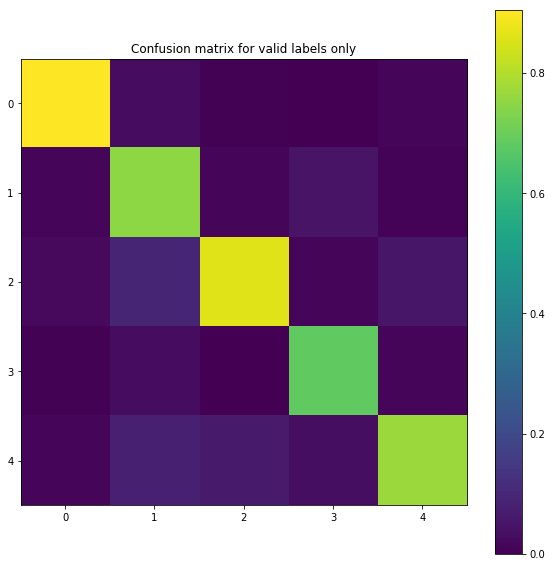

In [61]:
plt.figure(figsize = (10, 10));
plt.title("Confusion matrix for valid labels only")
plt.imshow(res[np.unique(valid_labels), np.unique(valid_labels).reshape(-1, 1)]);
plt.colorbar();

In [62]:
label_set

['go', 'yes', 'sheila', 'right', 'three', 'cat', 'one', 'on', 'bed', 'nine']

In [63]:
np.array(label_set)[(np.unique(valid_labels))]

array(['yes', 'right', 'three', 'one', 'bed'],
      dtype='|S6')